# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных:

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целью исследования является разработка модели машинного обучения , которая сможет предсказать рыночную стоимость автомобиля на основе технических характеристиках, комплектации и других признаков.

Исследование разделим на этапы:
- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Корреляционный анализ
- Обучение моделей
- Анализ моделей
- Выводы

## Подготовка данных

### Загрузка данных

In [ ]:
# !pip install scikit-learn==1.5 shap phik matplotlib==3.5.1 -q

In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor 
from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from phik import phik_matrix
import shap

TEST_SIZE = 0.2
RANDOM_STATE = 42

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.shape

(354369, 16)

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Вывод:** в датасете *df* 354369 записей и 16 признаков. Столбцы `Price`, `RegistrationYear`, `Power`, `Kilometer`, `RegistrationMonth`, `NumberOfPictures`, `PostalCode` имеют тип данных - int64, остальные - object. Пропуски содержаться в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`.

### Предобработка данных

Заменим верблюжий стиль написания названий столбцов на змеиный.

In [8]:
def camel_to_snake(camel_case_str):
    snake_case_str = ''
    for i, char in enumerate(camel_case_str):
        if char.isupper() and i != 0:
            snake_case_str += '_' + char.lower()
        else:
            snake_case_str += char.lower()
    return snake_case_str

In [9]:
df.columns = [camel_to_snake(col) for col in df.columns]
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Изменим тип данных столбцов `date_crawled`, `date_created`, `last_seen` на тип datetime64.

In [10]:
date_columns = ['date_crawled', 'date_created', 'last_seen']
df[date_columns] = df[date_columns].apply(
    lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))

Рассмотрим подробнее значения в столбцах с категориальными переменными.

In [11]:
def show_unique_categorical_values(df, max_unique=30, show_counts=False):
    # Выбираем категориальные столбцы
    categorical_cols = df.select_dtypes(include='object').columns
    
    if not categorical_cols.empty:
        print("Уникальные значения в категориальных столбцах:\n" + "-" * 50)
        for col in categorical_cols:
            unique_values = df[col].unique()
            num_unique = len(unique_values)
            
            print(f"\nСтолбец '{col}' ({num_unique} уникальных):")
            
            if num_unique <= max_unique:
                if show_counts:
                    print(df[col].value_counts().to_string())
                else:
                    print(np.array2string(unique_values, separator=', ', threshold=max_unique))
            else:
                print(f"Показано первых {max_unique} из {num_unique}:")
                print(np.array2string(unique_values[:max_unique], separator=', ', threshold=max_unique))
    else:
        print("В датафрейме нет категориальных столбцов.")

In [12]:
show_unique_categorical_values(df, max_unique=20, show_counts=True)

Уникальные значения в категориальных столбцах:
--------------------------------------------------

Столбец 'vehicle_type' (9 уникальных):
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288

Столбец 'gearbox' (3 уникальных):
manual    268251
auto       66285

Столбец 'model' (251 уникальных):
Показано первых 20 из 251:
['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
 '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
 'scirocco', '5er', 'meriva', 'arosa', 'c4']

Столбец 'fuel_type' (8 уникальных):
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90

Столбец 'brand' (40 уникальных):
Показано первых 20 из 40:
['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat', 'citroen', 'honda',
 '

Заполним пропущенные значения для различных столбцов. Для столбцов `repaired` заполним пропуски заглушкой 'unknown', для столбцов `vehicle_type`, `gearbox`, `fuel_type` - заполним модой, для записей с пропущенным значением `model` используем название бренда.

In [13]:
df['model'] = df['model'].fillna(df['brand'])
df['repaired'] = df['repaired'].fillna('unknown')

cols_to_fill_mode = ['vehicle_type', 'gearbox', 'fuel_type']
# заполним выбранные столбцы с пропусками значениями мод
for col in cols_to_fill_mode:
    df[col] = df[col].fillna(df[col].mode()[0])

In [14]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

**Вывод:** В ходе предобработки был изменен тип данных столбцов `date_crawled`, `date_created`, `last_seen` на тип datetime64, для столбца `repaired` пропуски заполнены заглушкой 'unknown', для столбцов `vehicle_type`, `gearbox`, `fuel_type` - модой, для `model` - значением `brand`.

### Исследовательский анализ данных

In [15]:
def num_col_graphics(df, column, figsize=(16, 12)):
    
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    sns.histplot(data=df, x=column, ax=axes[0], bins=50, color='lightskyblue', edgecolor='black', kde=True)
    axes[0].set_title(f'Гистограмма распределния признака {column}')
    axes[0].set_xlabel(f'Распределение по признаку {column}\n')
    axes[0].set_ylabel('Частота')
    
    sns.boxplot(data=df, x=column, ax=axes[1], color='lightskyblue')
    axes[1].set_title(f'\n\n"Ящик с усами" для признака {column}')
    axes[1].set_xlabel(f'Распределение по признаку {column}')
    
    
def discret_col_graphics(df, column, figsize=(16, 6)):
    
    plt.figure(figsize=figsize)
    
    sns.countplot(data=df, y=column, color='lightskyblue', edgecolor='black', alpha=0.6)
    plt.title(f'Диаграмма распределения признака {column}')
    plt.xlabel('Частота')
    plt.ylabel(f'Значения столбца {column}')


def cat_col_graphics(df, column, figsize=(16, 6)):
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    sns.countplot(data=df, x=column, ax=axes[0], color='lightskyblue', edgecolor='black', alpha=0.6)
    axes[0].set_title(f'Диаграмма распределения признака {column}')
    axes[0].set_xlabel(f'Значения столбца {column}\n')
    axes[0].set_ylabel('Частота')
    
    df[column].value_counts().plot.pie(ax=axes[1], autopct='%.1f%%', 
                                       wedgeprops={'edgecolor': 'black', 'linewidth': 1})
    axes[1].set_title(f'Круговая диаграмма для признака {column}')
    axes[1].set_ylabel('')

In [16]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,audi,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Для исследовательского анализа визуализируем распределение признаков нашего датасета. Но сначала избавимся от признаков, не несущих полезную для определения нашей целевого признака информацию. В числе этих признаков - `date_created`, `postal_code`, `last_seen`, `number_of_pictures`.

In [17]:
df = df.drop(['date_crawled', 'postal_code', 'last_seen', 'number_of_pictures'], axis=1)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24
1,18300,coupe,2011,manual,190,audi,125000,5,gasoline,audi,yes,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31


Рассмотрим подробнее признак `price`.

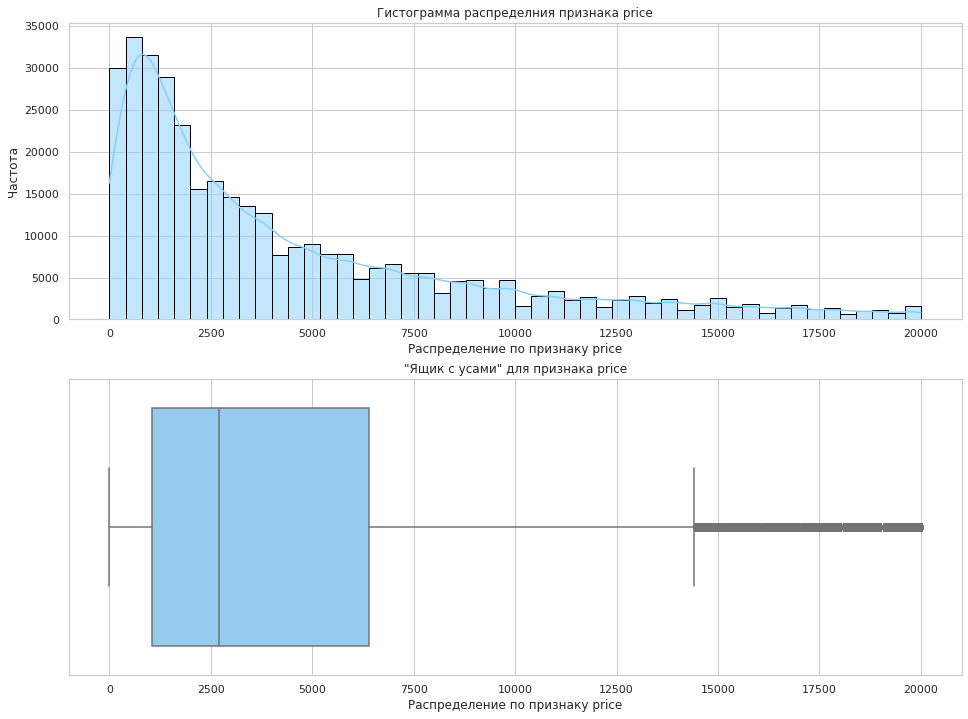

In [18]:
sns.set_theme(style='whitegrid', palette='pastel')
eda_start_shape = df.shape
num_col_graphics(df, 'price')

Рассмотрим подробнее околонулевые значения таргет переменной `price`.

In [19]:
print(df.query('price <= 2').shape)
df.query('price <= 2').head()

(11973, 12)


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21
40,0,sedan,1990,manual,0,corsa,150000,1,petrol,opel,unknown,2016-03-26
59,1,suv,1994,manual,286,sonstige_autos,150000,11,petrol,sonstige_autos,unknown,2016-03-29
89,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28
111,0,sedan,2017,manual,0,golf,5000,12,petrol,volkswagen,unknown,2016-03-19


Избавимся от этих значений, т.к. они могут негативно повлиять на предсказательную способность нашей модели.

In [20]:
df = df.query('price > 2')

Рассмотрим подробнее признак `vehicle_type`.

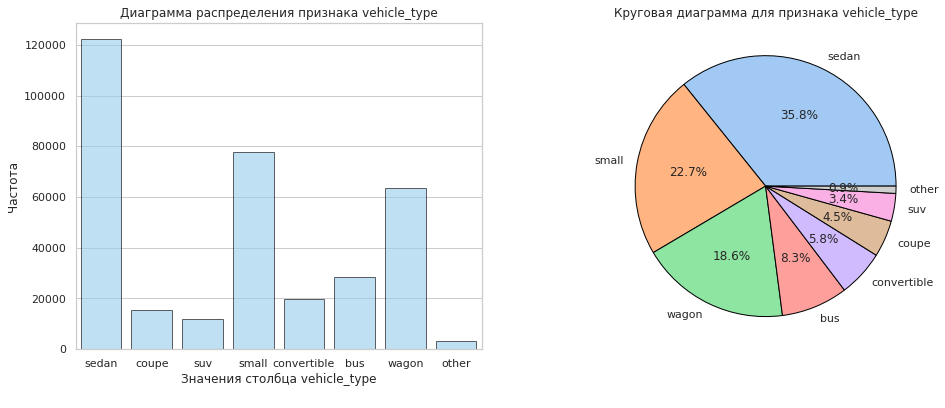

In [21]:
cat_col_graphics(df, 'vehicle_type')

Рассмотрим подробнее признак `registration_year`.

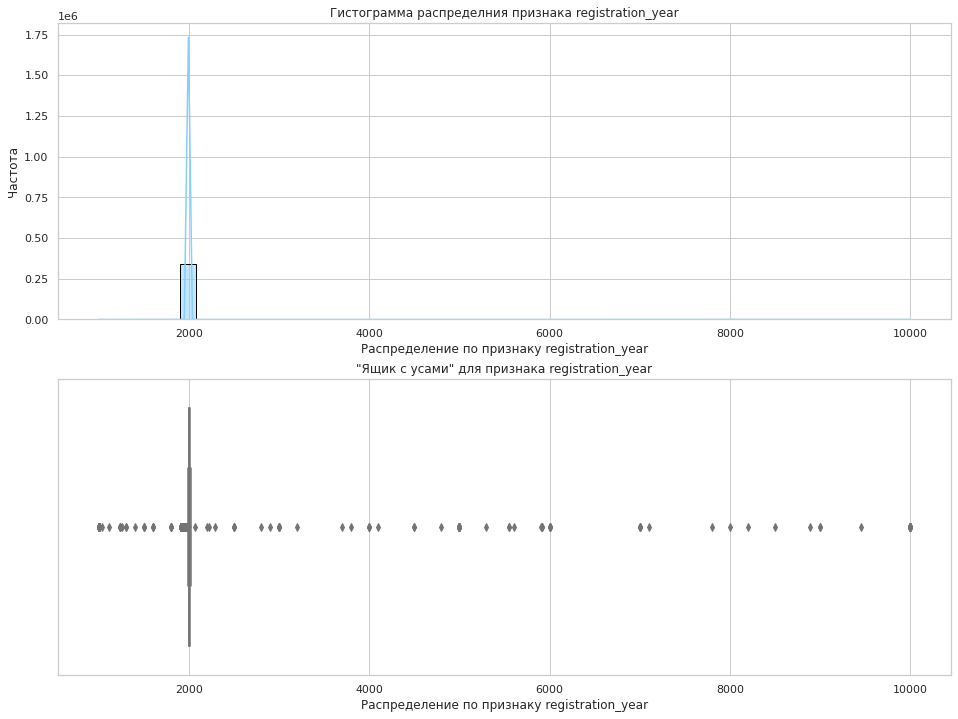

In [22]:
num_col_graphics(df, 'registration_year')

Во-первых, определим, в каких дата регистрации автомобиля больше, чем дата создания объявления для удаления явных выбросов.

In [23]:
query = '(registration_year > date_created.dt.year) | ' + \
        '((registration_year == date_created.dt.year) & (registration_month > date_created.dt.month))'
print(df.query(query).shape)
df.query(query).head()

(18649, 12)


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created
22,2900,sedan,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23
26,5555,sedan,2017,manual,125,c4,125000,4,petrol,citroen,no,2016-03-10
31,899,sedan,2016,manual,60,clio,150000,6,petrol,renault,unknown,2016-03-29
35,350,sedan,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08
48,7750,sedan,2017,manual,80,golf,100000,1,petrol,volkswagen,unknown,2016-03-25


Всего 18649 записей, не удовлетворящих условию, избавимся от них, а также от объявлений с датой регистрации автомобиля раньше 1980 года. Удалим признаки `date_created` и `registration_month`, т.к они не нужны для дальнейшего анализа и неинформативны для моделей.

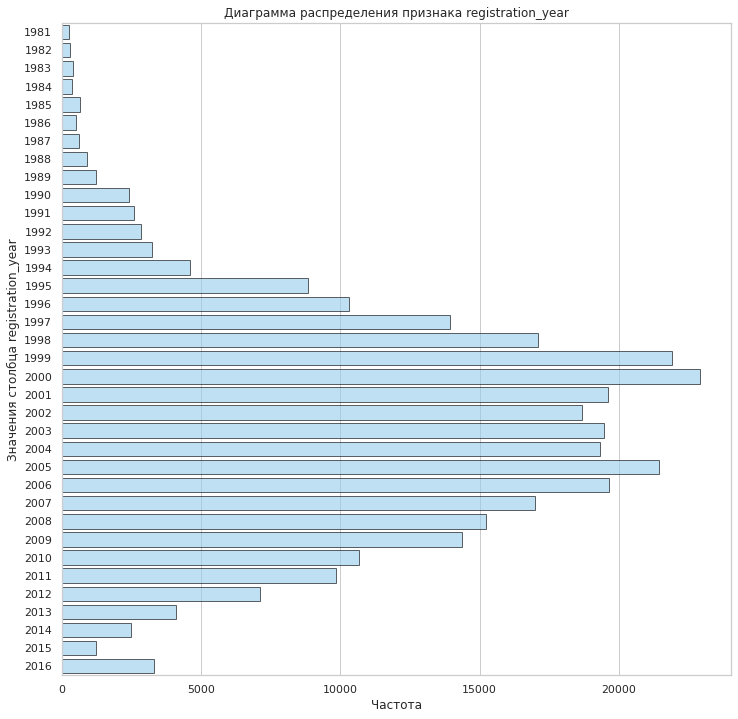

In [24]:
df = df.query('(1980 < registration_year < date_created.dt.year) | \
              ((registration_year == date_created.dt.year) & (registration_month < date_created.dt.month))')
df = df.drop(['date_created', 'registration_month'], axis=1)
discret_col_graphics(df, 'registration_year', figsize=(12, 12))

Рассмотрим подробнее признак `gearbox`.

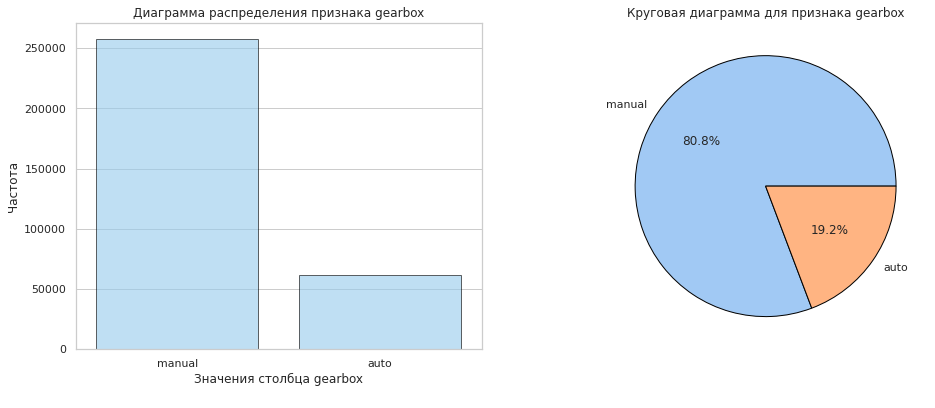

In [25]:
cat_col_graphics(df, 'gearbox')

Рассмотрим подробнее признак `power`.

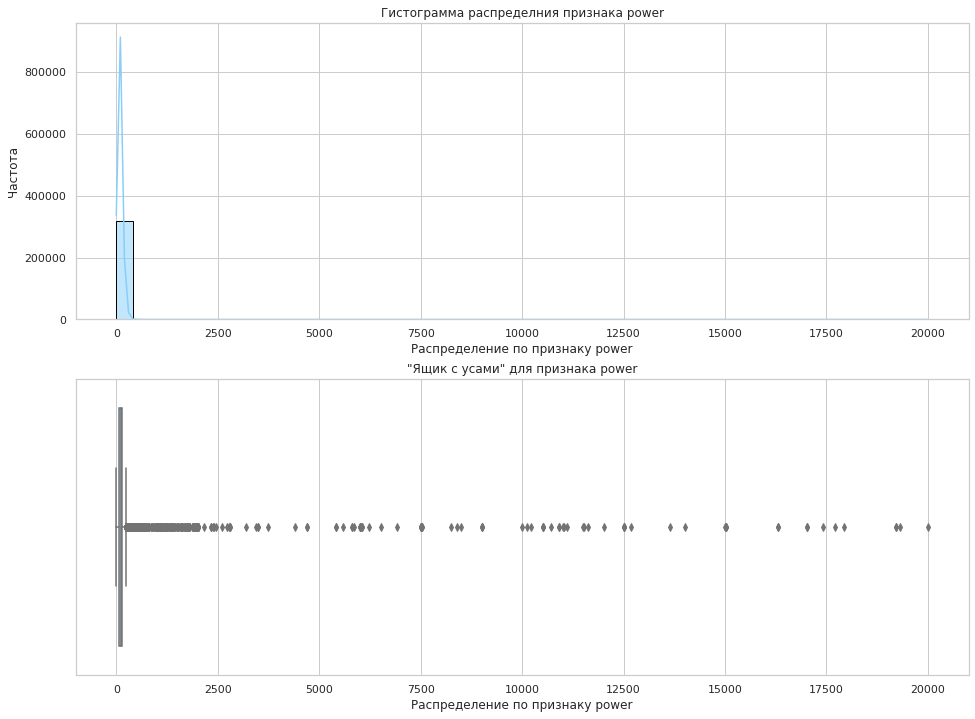

In [26]:
num_col_graphics(df, 'power')

Видим большое количество выбросов. Оценим насколько много данных сосредоточено в этих выбросах.

In [27]:
print(df.query('power > 350').shape)
df.query('power > 350').head()

(1051, 10)


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2406,13500,sedan,2006,auto,396,5er,150000,petrol,bmw,unknown
2781,19500,suv,2004,auto,450,cayenne,125000,petrol,porsche,no
2901,12900,sedan,2006,auto,387,s_klasse,150000,petrol,mercedes_benz,no
3245,15500,sedan,2006,auto,387,s_klasse,150000,petrol,mercedes_benz,no


Всего 1051 записей нашего датасета имеют мощность более 350 л.с.

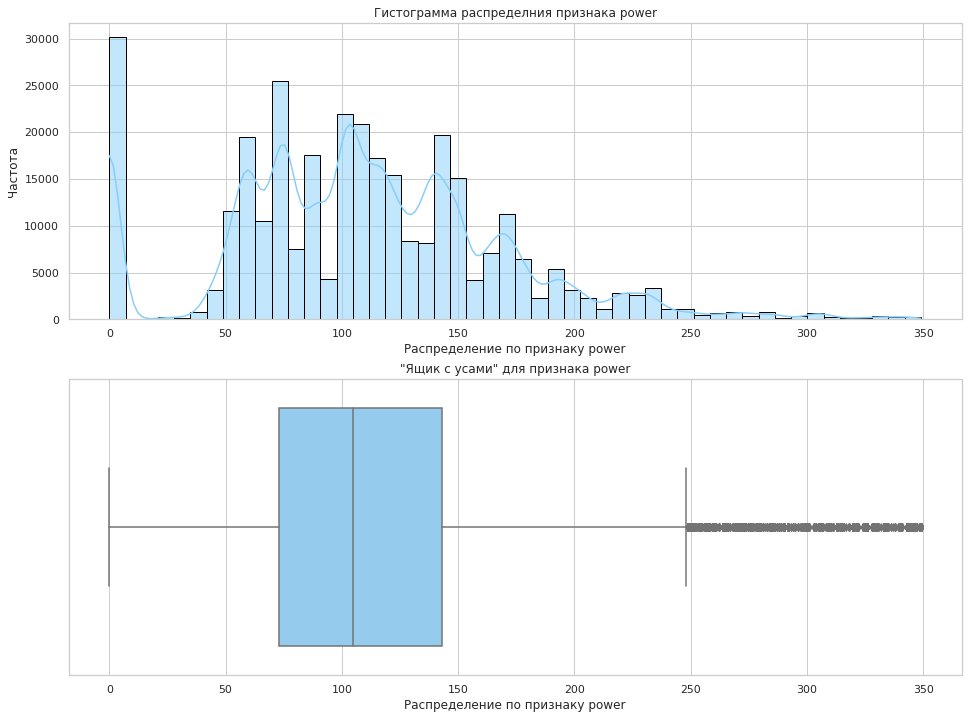

In [28]:
df = df.query('power < 350')
num_col_graphics(df, 'power')

Также видим большое количество значений (примерно 30 тысяч) около нуля, рассмотрим их подробнее.

In [29]:
print(df.query('power < 20').shape)
df.query('power < 20').head()

(30274, 10)


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,unknown
32,245,sedan,1994,manual,0,golf,150000,petrol,volkswagen,no
37,1500,sedan,2016,manual,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,petrol,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes


Сложно сказать, почему у многих машин записана такая низкая мощность равная или близкая к нулю, скорее всего это связано с ошибками при подаче объявления. Заменим эти значения на  медианные значение лошадиных сил для модели машины.

In [30]:
median_power = df.groupby('model')['power'].transform('median')
df['power'] = np.where(df['power'] < 20, median_power, df['power'])

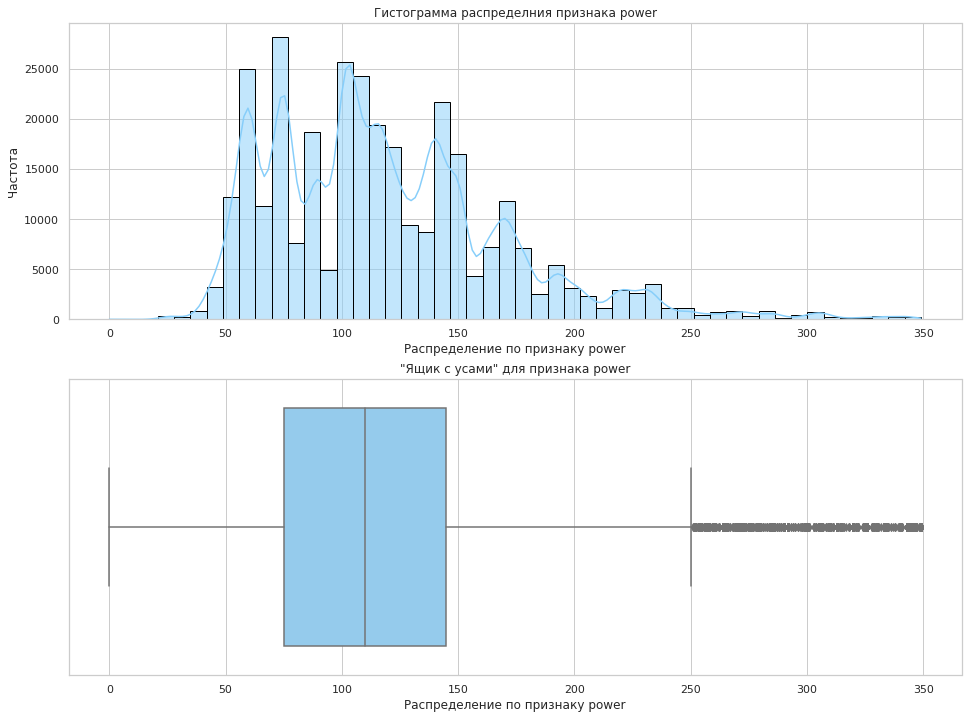

In [31]:
num_col_graphics(df, 'power')

Также избавимся о значений менее 25 лошадиных сил, все равно оставшихся после преобразования.

In [32]:
df = df.query('power > 25')

Рассмотрим подробнее признак `kilometer`.

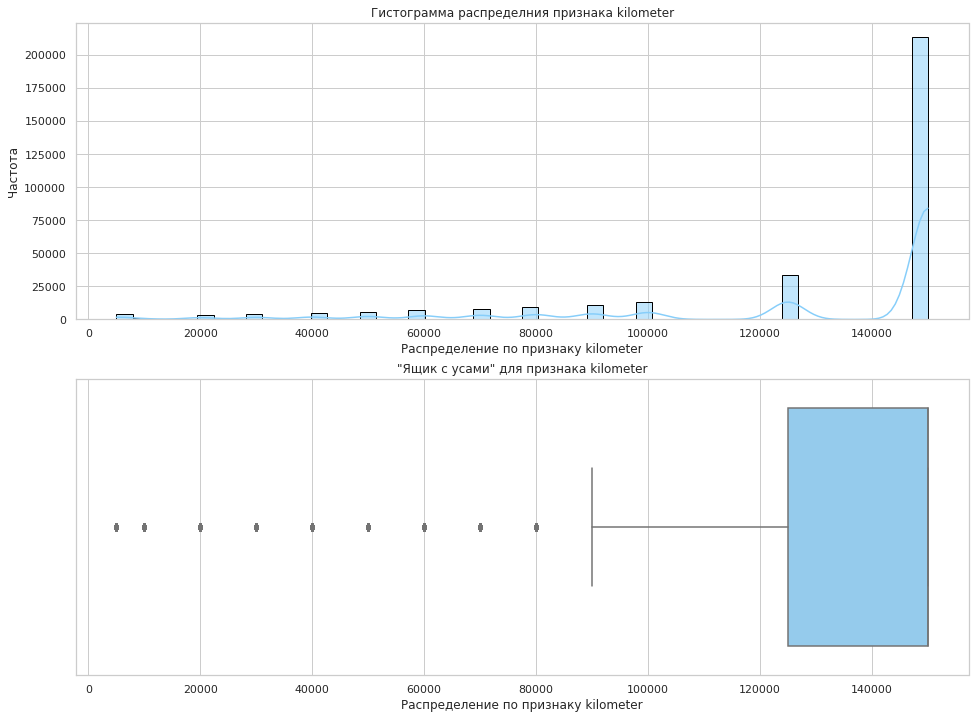

In [33]:
num_col_graphics(df, 'kilometer')

Рассмотрим подробнее признак `fuel_type`.

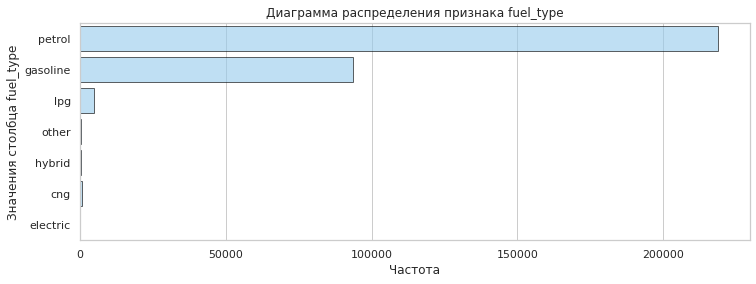

In [34]:
discret_col_graphics(df, 'fuel_type', figsize=(12, 4))

Рассмотрим подробнее признак `brand`.

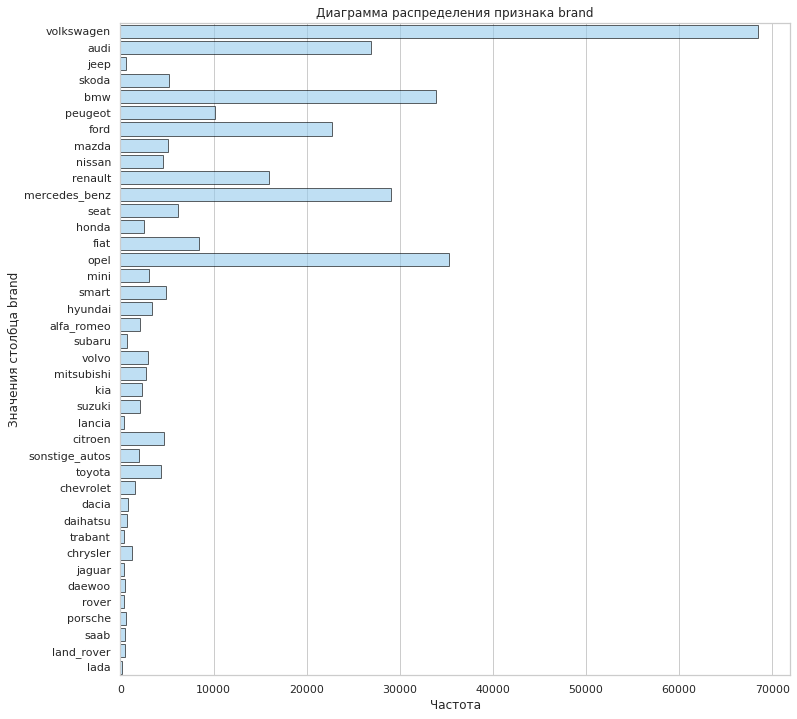

In [35]:
discret_col_graphics(df, 'brand', figsize=(12, 12))

Рассмотрим подробнее признак `repaired`.

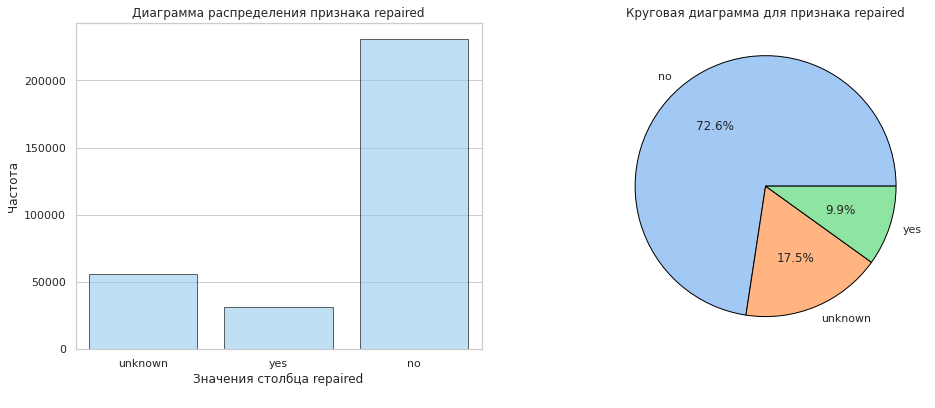

In [36]:
cat_col_graphics(df, 'repaired')

In [37]:
num_of_deleted_rows = eda_start_shape[0] - df.shape[0]
print(f'В результате EDA было удалено {num_of_deleted_rows} записей, {num_of_deleted_rows / eda_start_shape[0]:.2%}.')

В результате EDA было удалено 36016 записей, 10.16%.


**Вывод:** В ходе исследовательского анализа данных были проведены следующие действия:
- Удалены признаки `date_crawled`, `postal_code`, `last_seen`, `number_of_pictures`.
- Удалены записи, в которых цена автомобиля менее 2 евро.
- Удалены записи, в которых дата регистрации автомобиля больше, чем дата размещения обяъвления.
- Удалены признаки `date_created`, `registration_month`.
- Удалены записи, в которых мощность двигателя более 350 л.с и менее 25 л.с.

### Корреляционный анализ

Для корреляционного анализа используем корреляцию хи-квадрат.

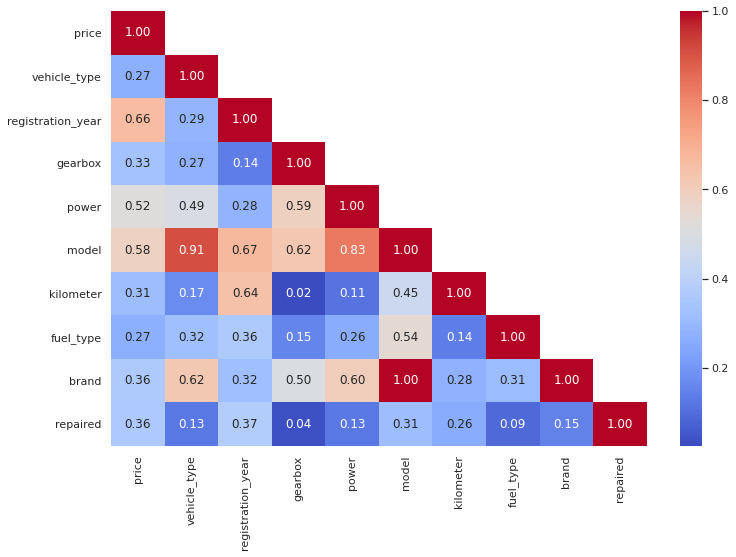

In [39]:
plt.figure(figsize=(12, 8))
phik_matrix = df.phik_matrix(interval_cols=['power', 'kilometer', 'price'])
masking = np.triu(np.ones_like(phik_matrix, dtype=bool), k=1)
sns.heatmap(data=phik_matrix, mask=masking, annot=True, cmap='coolwarm', fmt='.2f');

Видим, что `brand` абсолютно коррелирует с признаком `model`. Для избежания мультиколлинеарности сделаем дополнительный признак `brand_model` объединением и будем использовать его для моделей. Это особенно важно для линейных моделей, которые мы собираемся использовать.

In [40]:
df['brand_model'] = df['brand'] + '_' + df['model']

Заново построим матрицу корреляции с новым признаком.

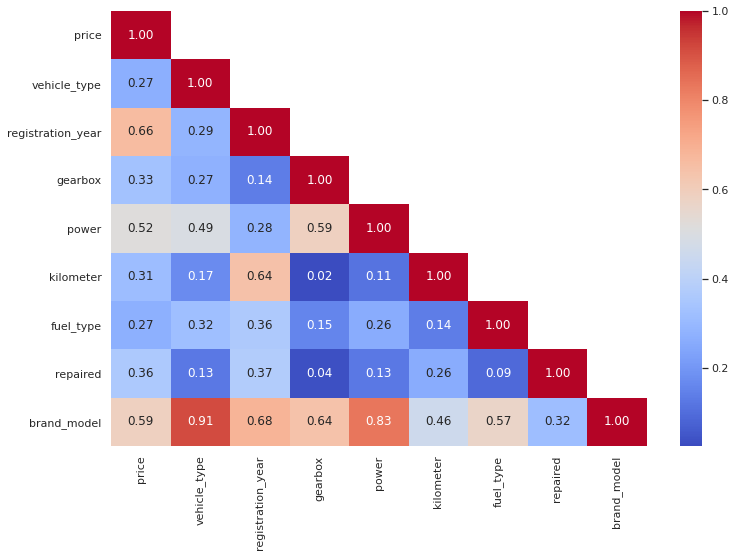

In [41]:
plt.figure(figsize=(12, 8))
phik_matrix = df.drop(['brand', 'model'], axis=1).phik_matrix(
    interval_cols=['power', 'kilometer', 'price'])
masking = np.triu(np.ones_like(phik_matrix, dtype=bool), k=1)
sns.heatmap(data=phik_matrix, mask=masking, annot=True, cmap='coolwarm', fmt='.2f');

Для других признаков мультиколлинеарности не обнаружено.

**Вывод:** В ходе корреляционного анализа был добавлен признак `brand_model`, объединяющий эти два признака в один.

## Обучение моделей

Подсчитаем количество полных строк дубликатов в датасете и избавимся от них.

In [42]:
df.duplicated().sum()

45989

In [43]:
df.drop_duplicates(inplace=True)

In [44]:
X = df.drop(['price', 'brand', 'model'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [45]:
ohe_columns = ['vehicle_type',
              'gearbox',
              'fuel_type',
              'repaired']

target_columns = ['brand_model',
              'registration_year']

num_columns = ['power',
              'kilometer']

In [46]:
ohe_pipe = Pipeline(
    [('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

target_pipe = Pipeline(
    [('simpleImputer_before_target', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('target', TargetEncoder(target_type="continuous", random_state=RANDOM_STATE))])

In [47]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('target', target_pipe, target_columns),
     ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [48]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [56]:
param_grid = [
    # LinearRegression с масштабированием y
    {
        'models': [TransformedTargetRegressor(
            regressor=LinearRegression(),
            transformer=StandardScaler()
        )]
    },
    
    # DecisionTree и LGBM — без масштабирования y
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 13)
    },

    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(8, 11)
    }
]

In [57]:
gs = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'fuel_type',
                                                                          'repaired']),
                                                                        ('target'...
                                        DecisionTreeRegressor(max_depth=12,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [TransformedTargetRegressor(regressor=LinearRegression(),
                                                                transformer=StandardScaler())]},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(10, 13)},
                         {'models': [LGBMRegressor(random_state=42)],
                          'models__max_depth': range(8, 11)}],
             scoring='neg_root_mean_squared_error')

In [58]:
print('Лучшая модель и её параметры:\n\n', gs.best_estimator_)
print (f'Метрика лучшей модели RMSE при кросс-валидации: {-gs.best_score_:.3f} евро')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'fuel_type', 'repaired']),
                                                 ('target',
                 

In [59]:
y_pred = gs.predict(X_test)
print(f'RMSE модели на тестовых данных: {root_mean_squared_error(y_test, y_pred):.3f} евро')

RMSE модели на тестовых данных: 1733.645 евро


**Вывод:**
В ходе моделирования была найдена и обучена модель для определения стоимости автомобиля. Лучшие результаты показала модель градиентного бустинга **LGBMRegressor(max_depth=10, random_state=42)**. Её показатели RMSE для тренировочной выборки - 1728.910 евро, для тестовой выборки - 1733.645 евро. 

## Анализ моделей

Оценим время обучения, время вычисления метрики (включающее время предсказания + расчет метрики) и RMSE для наших моделей.

In [60]:
models_dict = {
        'model': [],
        'max_depth': [],
        'fit_time': [],
        'score_time': [],
        'test_score': []
    }

for params, mean_fit_time, mean_score_time, mean_test_score in zip(
    gs.cv_results_['params'],
    gs.cv_results_['mean_fit_time'],
    gs.cv_results_['mean_score_time'],
    gs.cv_results_['mean_test_score']):  
    
    if isinstance(params['models'], TransformedTargetRegressor):
        models_dict['model'].append(params['models'].regressor)
        models_dict['max_depth'].append('-')
    else:
        models_dict['model'].append(params['models'])
        models_dict['max_depth'].append(params['models__max_depth'])
    models_dict['fit_time'].append(mean_fit_time)
    models_dict['score_time'].append(mean_score_time)
    models_dict['test_score'].append(-mean_test_score)
    
pd.DataFrame(models_dict).round(3)

,model,max_depth,fit_time,score_time,test_score
0,LinearRegression(),-,1.089,0.230,2249.186
1,DecisionTreeRegressor(random_state=42),10,1.402,0.133,1940.236
2,DecisionTreeRegressor(random_state=42),11,1.407,0.130,1916.436
3,DecisionTreeRegressor(random_state=42),12,1.428,0.129,1917.390
4,LGBMRegressor(random_state=42),8,12.793,0.443,1734.294
5,LGBMRegressor(random_state=42),9,9.176,0.477,1731.867
6,LGBMRegressor(random_state=42),10,4.475,0.425,1728.910


**LightGBM** показывает лучшее качество (низкий RMSE), но требуют больше времени на обучение.

**LinearRegression** — самая быстрая, но менее точная модель. Подойдет, если важна скорость предсказания.

**DecisionTreeRegressor** — компромисс между скоростью и качеством, качество ниже, чем у **LightGBM**, но существенно быстрее.

Исходя из критериев заказчика, выберем модель дерева решений и оценим её на тестовых данных.

In [61]:
tree_model = pipe_final.set_params(**gs.cv_results_['params'][3])
tree_model.fit(X_train, y_train)
y_tree_pred = tree_model.predict(X_test)
print(f'Показатель RMSE на тестовых данных для выбранной модели - {root_mean_squared_error(y_test, y_tree_pred):.3f}')

Показатель RMSE на тестовых данных для выбранной модели - 1895.896


Результат нашей выбранной модели **DecisionTreeRegressor(max_depth=12, random_state=42)** на тестовых данных - 1895.896 евро.

Также проанализируем значимость признаков для выбранной модели с помощью shap значений.

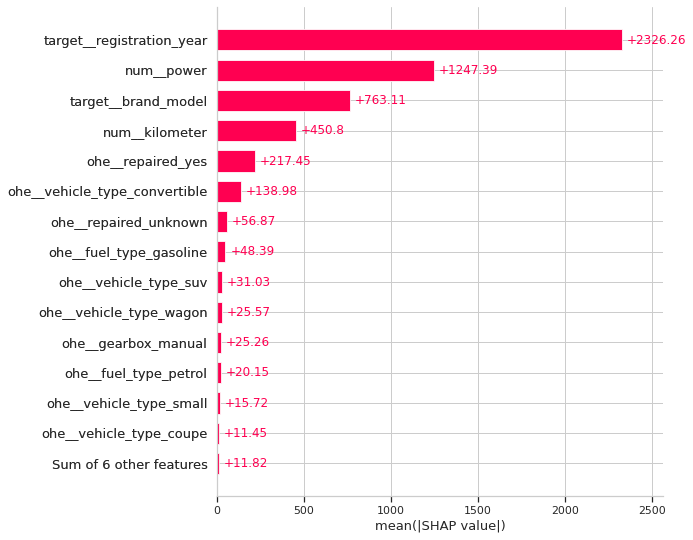

None

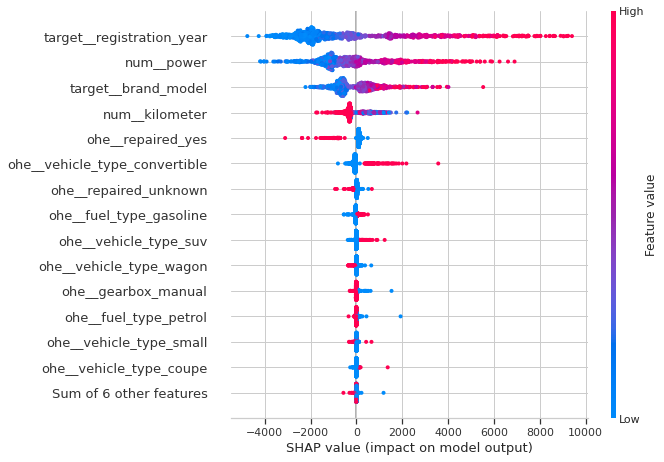

In [62]:
explainer = shap.TreeExplainer(tree_model.named_steps['models'])

X_test_2 = tree_model.named_steps['preprocessor'].transform(X_test[:1000])

feature_names = tree_model.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)
 
shap_values = explainer(X_test_2)
 
display(shap.plots.bar(shap_values, max_display=15))
shap.plots.beeswarm(shap_values, max_display=15)

Важнейший признак для нашей модели - это **год регистрации автомобиля**, далее идёт **количество лошадиных сил**, **бренд и модель** автомобиля и **пробег**.

## Выводы

В ходе работы была разработана и протестирована модель для прогнозирования рыночной стоимости автомобилей. Наилучшие результаты продемонстрировал **градиентный бустинг (LGBMRegressor)** с параметрами `max_depth=10` и `random_state=42`:

- **RMSE на тренировочных данных: 1728.910 евро**

- **RMSE на тестовых данных: 1733.645 евро**

Несмотря на высокую точность, LightGBM требует **больше времени на обучение**, что может быть критично для реального использования в приложении.

**Сравнение моделей**
1. LightGBM

    - **Плюсы:** Лучшее качество (наименьший RMSE).

    - **Минусы:** Дольше обучается.


2. LinearRegression

    - **Плюсы:** Самая быстрая модель (минимальное время предсказания).

    - **Минусы:** Низкая точность (RMSE выше на ~15-20%).


3. DecisionTreeRegressor

    - **Плюсы:** Компромисс между скоростью и качеством.

    - **Минусы:** Уступает LightGBM в точности, но работает значительно быстрее.

**Выбор оптимальной модели**

Исходя из требований заказчика (баланс между точностью и скоростью), **выбрана модель DecisionTreeRegressor** с параметрами `max_depth=12` и `random_state=42`. Её результаты:

- **RMSE на тестовых данных: 1895.896 евро** (приемлемая точность для MVP).

- **Время предсказания: В 3-5 раз быстрее LightGBM**, что критично для работы в реальном времени.

**Анализ значимости признаков**

С помощью **SHAP-значений** определены ключевые факторы, влияющие на стоимость автомобиля:

1. **Год регистрации** (наибольшая важность).

2. **Мощность двигателя (л.с.)**.

3. **Бренд и модель автомобиля**.

4. **Пробег**.

**Рекомендации**

Для первой версии приложения использовать DecisionTreeRegressor — оптимальное сочетание скорости и точности.

В будущем можно доработать модель, внедрив LightGBM с оптимизированными гиперпараметрами, если позволит инфраструктура.
